In [1]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
from datasets import load_dataset
from analysis_utils import *
%load_ext autoreload
%autoreload 2

In [2]:
def get_verdict_ids_from_batch(verdict_group_batch):
    with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
        data = json.load(f)

    verdict_ids = []
    for run in data["runs"]:
        verdict_ids.append(run['verdict_run_id'])

    return verdict_ids, data

Plot 1

In [ ]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)

In [6]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [7]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['config_model_name_qa_judge'])
aggregate_acc = aggregate_acc.iloc[0:-1:4]


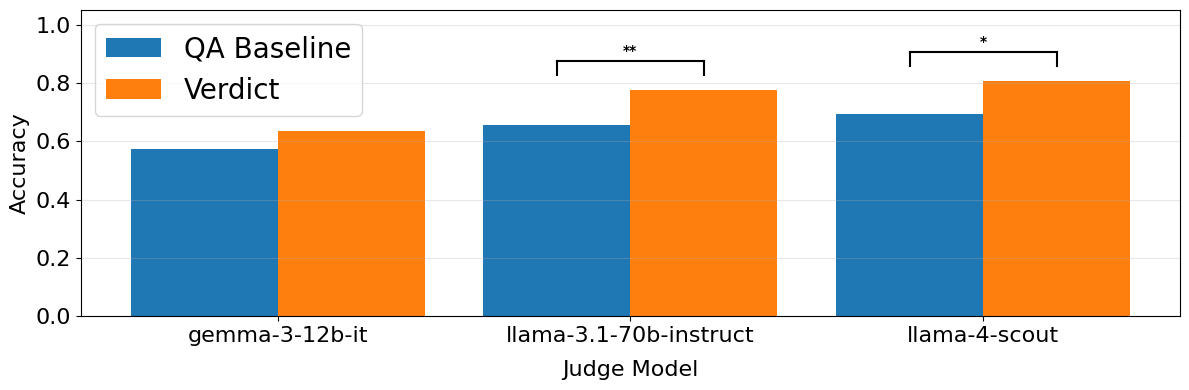

In [8]:
from plot_utils import *
aggregate_acc = aggregate_acc[aggregate_acc['name'] != 'x-ai/grok-4-fast']
plot_results_by_name(aggregate_acc, plot_gap_and_gain=False)
plt.show()

Plot 2

In [20]:
verdict_group_batch = "4r30ivy"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)

In [21]:
verdict_ids

['1fj2i05',
 'juku5ze',
 'qglv702',
 '2w6ge2u',
 '6pimftp',
 't9icnd3',
 'b8gewd2',
 'krk0a9q',
 '7qy5yv0',
 'khnl8h5',
 '04b8m8o']

In [22]:
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [30]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])

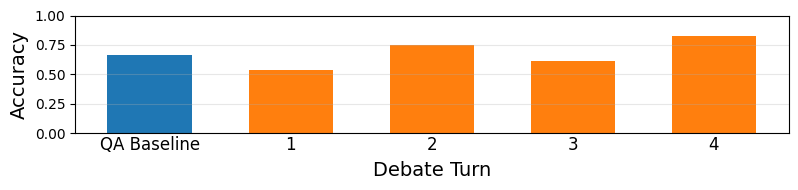

In [33]:
for run_idx in [0]:
    run_mapping = pd.DataFrame(data['runs'])
    merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted([x for x in plot_data['upto_turns'].dropna().unique()])
        upto_turns_list = upto_turns_list[:-6]
        upto_turns_list = [x for x in upto_turns_list if x != 0]
    else:
        upto_turns_list = [None]
    
    n_bars = 1 + len(upto_turns_list)
    x = np.arange(n_bars)
    width = 0.6
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    rows = plot_data
    judge_qa_value = rows['judge_qa_acc'].mean()
    judge_qa_n_correct = int(rows['judge_qa_n_correct'].sum())
    judge_qa_n_total = int(rows['n_judge_qa_not_null'].sum())
    
    bar_judge_qa = ax.bar(0, judge_qa_value, width, label='QA Baseline', alpha=1.0, color='C0')
    ax.text(0, -0.02, 'QA Baseline', ha='center', va='top', fontsize=12)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        if len(turn_data) > 1:
            raise Exception('Check why rows greater than 1')
        
        verdict_value = turn_data.iloc[0]['verdict_acc']
        verdict_n_correct = int(turn_data.iloc[0]['verdict_n_correct'])
        verdict_n_total = int(turn_data.iloc[0]['n_verdict_not_null'])
        
        bar_idx = i + 1
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bar = ax.bar(bar_idx, verdict_value, width, label=label, alpha=1.0, color='C1')
        
        turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
        ax.text(bar_idx, -0.02, turn_label, ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Debate Turn', fontsize=14, labelpad=20)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    # ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

Plot 3

In [34]:
debate_run_id = 'suu380s'
df = prepare_df(['debates'])
df = df[df['run_id_debates'] == debate_run_id]
df.shape

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


(197, 49)

In [35]:
correct_debater_response_times = []
incorrect_debater_response_times = []
correct_reasoning_tokens = []
incorrect_reasoning_tokens = []
from collections import defaultdict
correct_by_turn_dict = defaultdict(list)
incorrect_by_turn_dict = defaultdict(list)
correct_reasoning_by_turn_dict = defaultdict(list)
incorrect_reasoning_by_turn_dict = defaultdict(list)
for idx, row in df.iterrows():
    correct_idx = row['correct_idx_debates']
    num_correct_turns = 0
    num_incorrect_turns = 0
    for turn in row['debate_history_debates']:
        reasoning_tokens = get_reasoning_tokens(turn)
        if turn['debater_idx'] == correct_idx:
            correct_debater_response_times.append(turn['response_time'])
            correct_reasoning_tokens.append(reasoning_tokens)
            correct_by_turn_dict[num_correct_turns].append(turn['response_time'])
            correct_reasoning_by_turn_dict[num_correct_turns].append(reasoning_tokens)
            num_correct_turns += 1
        elif turn['debater_idx'] != correct_idx:
            incorrect_debater_response_times.append(turn['response_time'])
            incorrect_reasoning_tokens.append(reasoning_tokens)
            incorrect_by_turn_dict[num_incorrect_turns].append(turn['response_time'])
            incorrect_reasoning_by_turn_dict[num_incorrect_turns].append(reasoning_tokens)
            num_incorrect_turns += 1
correct_debater_response_times = pd.Series(correct_debater_response_times)
incorrect_debater_response_times = pd.Series(incorrect_debater_response_times)
correct_reasoning_tokens = pd.Series(correct_reasoning_tokens)
incorrect_reasoning_tokens = pd.Series(incorrect_reasoning_tokens)

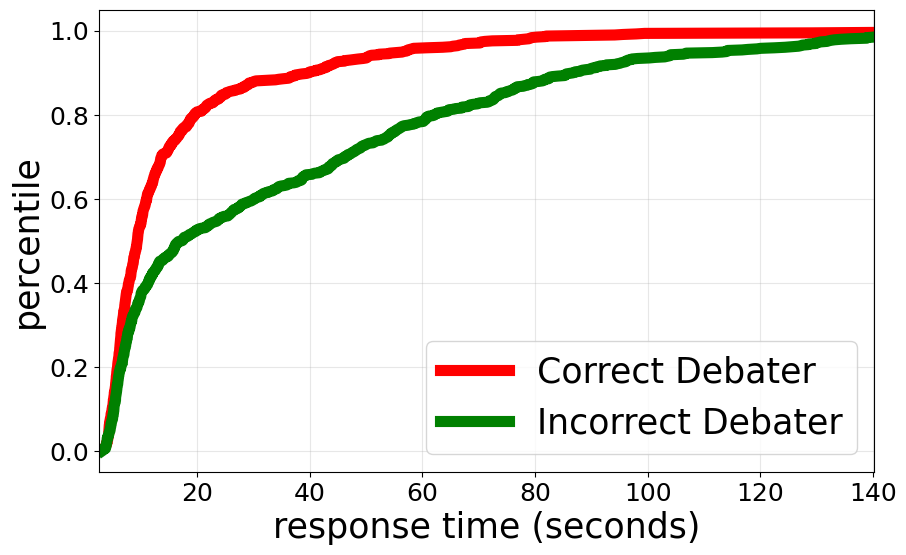

In [36]:
ax = cdf((correct_debater_response_times, incorrect_debater_response_times), labels=['Correct Debater', 'Incorrect Debater'], xlim_percentiles=[0, 99])
plt.xlabel('response time (seconds)', fontsize=25)
plt.ylabel('percentile', fontsize=25)
plt.show()

Plot 4

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


Accuracy: 0.889
Brier Score: 0.0711
Baseline Brier Score (always predict 0.5): 0.2500


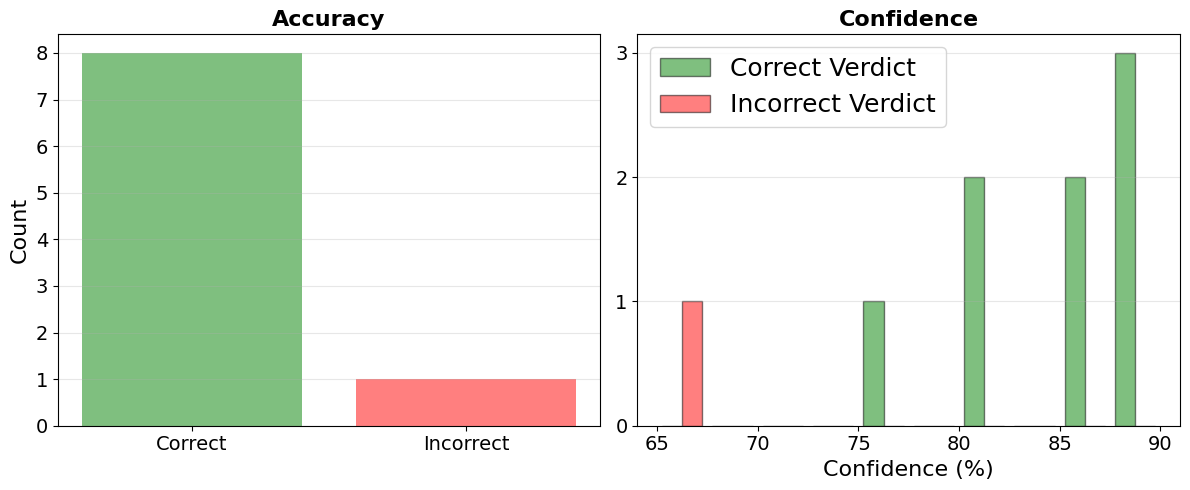


Brier Score: 0.0711
Baseline Brier Score: 0.2500
Improvement: 0.1789


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *

human_verdicts_file = '../results/human/human_verdicts.jsonl'
human_df = pd.read_json(human_verdicts_file, lines=True)

run_id = '0vayjit'
human_df = human_df[human_df['run_id'] == run_id]

debates_df = prepare_df(['debates'])
debates_df = debates_df[debates_df['run_id_debates'] == run_id]

merged = human_df.merge(debates_df[['run_id_debates', 'record_id_debates', 'correct_idx_debates']], 
                        left_on=['run_id', 'record_id'], 
                        right_on=['run_id_debates', 'record_id_debates'])

merged['verdict'] = merged['verdict'].astype(int)
merged['correct_idx_debates'] = merged['correct_idx_debates'].astype(int)
merged['confidence'] = merged['confidence'].astype(float) / 100.0

merged['is_correct'] = merged['verdict'] == merged['correct_idx_debates']

accuracy = merged['is_correct'].mean()
print(f"Accuracy: {accuracy:.3f}")

def compute_brier_score(merged_df):
    brier_scores = []
    for _, row in merged_df.iterrows():
        verdict = row['verdict']
        confidence = row['confidence']
        correct = row['correct_idx_debates']
        
        if verdict == correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(merged)
print(f"Brier Score: {brier_score:.4f}")

baseline_brier = 0.25
print(f"Baseline Brier Score (always predict 0.5): {baseline_brier:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Correct', 'Incorrect'], [merged['is_correct'].sum(), (~merged['is_correct']).sum()], 
        color=['green', 'red'], alpha=0.5)
ax1.set_ylabel('Count', fontsize=16)
# ax1.set_title(f'Accuracy: {accuracy:.1%}', fontsize=14, fontweight='bold')
ax1.set_title(f'Accuracy',  fontsize=16, fontweight='bold')

ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='both', labelsize=14)

correct_conf = merged[merged['is_correct']]['confidence'] * 100
incorrect_conf = merged[~merged['is_correct']]['confidence'] * 100

ax2.hist([correct_conf, incorrect_conf], bins=10, alpha=0.5, 
         label=['Correct Verdict', 'Incorrect Verdict'], color=['green', 'red'], edgecolor='black')
ax2.set_xlabel('Confidence (%)', fontsize=16)
ax2.set_title('Confidence', fontsize=16, fontweight='bold')
ax2.legend(fontsize=18)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\nBrier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")

Comparison to LLM brier score

In [4]:
verdict_group_batch = "82ifg57"
verdict_ids, _ = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

KeyboardInterrupt: 

In [81]:
temp_df['parsed_confidence_verdicts'].isnull().sum()

np.int64(3)

In [83]:
temp_df = verdicts_df[verdicts_df['parsed_confidence_verdicts'].notnull()].copy()
print(f"Total rows: {len(temp_df)}")
print(f"Null confidence: {temp_df['parsed_confidence_verdicts'].isnull().sum()}")

def compute_brier_score(df):
    brier_scores = []
    for _, row in df.iterrows():
        confidence = row['parsed_confidence_verdicts'] / 100.0
        is_correct = row['is_correct_verdict']
        
        if is_correct:
            predicted_prob_correct = confidence
        else:
            predicted_prob_correct = 1.0 - confidence
        
        actual = 1.0
        brier_score = (predicted_prob_correct - actual) ** 2
        brier_scores.append(brier_score)
    
    return np.mean(brier_scores)

brier_score = compute_brier_score(temp_df)
baseline_brier = 0.25

print(f"Brier Score: {brier_score:.4f}")
print(f"Baseline Brier Score: {baseline_brier:.4f}")
print(f"Improvement: {baseline_brier - brier_score:.4f}")


Total rows: 2310
Null confidence: 0
Brier Score: 0.2164
Baseline Brier Score: 0.2500
Improvement: 0.0336


In [70]:
temp_df.shape

(197, 93)

In [66]:
llama_df['is_correct_qa_judge'].mean()

np.float64(0.6548223350253807)

In [84]:
(0.2164 - 0.0711) / .2164

0.6714417744916821

Plot 5

In [3]:
verdict_group_batch = "6irkzm1"
verdict_ids, data = get_verdict_ids_from_batch(verdict_group_batch)
verdicts_df = prepare_df(specific_verdict_ids=verdict_ids)
verdicts_df = verdicts_df[(verdicts_df['is_correct_qa_judge'].notnull()) & (verdicts_df['is_correct_verdict'].notnull()) & (verdicts_df['is_correct_qa_debater'].notnull())]

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(aligned_dfs, ignore_index=True)


In [4]:
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-4-scout') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-4-scout')]
verdicts_df = verdicts_df[(verdicts_df['config_model_name_qa_judge'] != 'meta-llama/llama-3.1-405b-instruct') & (verdicts_df['config_model_name_qa_debater'] != 'meta-llama/llama-3.1-405b-instruct')]

In [5]:
verdicts_df['config_model_name_qa_debater'].value_counts()

config_model_name_qa_debater
meta-llama/llama-3.3-70b-instruct    2101
openai/gpt-4o-mini                   2099
google/gemma-3-12b-it                2088
meta-llama/llama-3.1-70b-instruct    2082
openai/gpt-3.5-turbo                 2077
qwen/qwen-2.5-72b-instruct           2061
x-ai/grok-4-fast                     2052
meta-llama/llama-3-8b-instruct       2036
meta-llama/llama-4-maverick          2035
meta-llama/llama-3.1-8b-instruct     1995
google/gemma-3-27b-it                1628
Name: count, dtype: int64

In [22]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc = aggregate_acc.merge(verdicts_df[['verdict_run_id_verdicts', 'config_judge_model_verdicts', 'config_debater_model_debates']].drop_duplicates(), left_on='name', right_on='verdict_run_id_verdicts', how='inner')

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:209: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


In [23]:
aggregate_acc.head()

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,verdict_chose_idx_0,pgr,gap,gain,name,verdict_run_id_verdicts,config_judge_model_verdicts,config_debater_model_debates
0,0.666667,0.537415,0.578231,98,79,85,147,147,147,147,0.408163,0.315789,0.129252,0.040816,08j63km,08j63km,meta-llama/llama-3-8b-instruct,google/gemma-3-27b-it
1,0.564516,0.548387,0.569892,105,102,106,186,186,186,186,0.618280,1.333333,0.016129,0.021505,08no67x,08no67x,meta-llama/llama-3-8b-instruct,google/gemma-3-12b-it
2,0.658163,0.693878,0.581633,129,136,114,196,196,196,196,0.525510,3.142857,-0.035714,-0.112245,0emdwhu,0emdwhu,qwen/qwen-2.5-72b-instruct,meta-llama/llama-3.1-70b-instruct
3,0.579487,0.543590,0.574359,113,106,112,195,195,195,195,0.497436,0.857143,0.035897,0.030769,0ujm4qo,0ujm4qo,meta-llama/llama-3-8b-instruct,openai/gpt-4o-mini
4,0.544041,0.569948,0.580311,105,110,112,193,193,193,193,0.601036,-0.400000,-0.025907,0.010363,13pb1cy,13pb1cy,openai/gpt-4o-mini,meta-llama/llama-3-8b-instruct


In [38]:
verdict_avg = aggregate_acc.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg = aggregate_acc.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

temp = aggregate_acc[~aggregate_acc['config_judge_model_verdicts'].isin(['x-ai/grok-4-fast', 'meta-llama/llama-4-maverick'])]
verdict_avg_minus2 = temp.groupby('config_debater_model_debates')['verdict_acc'].mean()
qa_avg_minus2 = temp.groupby('config_debater_model_debates')['judge_qa_acc'].mean().mean()

print(verdict_avg, qa_avg)
print(verdict_avg_minus2, qa_avg_minus2)

config_debater_model_debates
google/gemma-3-12b-it                0.584744
google/gemma-3-27b-it                0.646737
meta-llama/llama-3-8b-instruct       0.617302
meta-llama/llama-3.1-70b-instruct    0.609251
meta-llama/llama-3.1-8b-instruct     0.634036
meta-llama/llama-3.3-70b-instruct    0.619556
meta-llama/llama-4-maverick          0.704813
openai/gpt-3.5-turbo                 0.608436
openai/gpt-4o-mini                   0.618571
qwen/qwen-2.5-72b-instruct           0.644094
x-ai/grok-4-fast                     0.703303
Name: verdict_acc, dtype: float64 0.651841336035787
config_debater_model_debates
google/gemma-3-12b-it                0.543209
google/gemma-3-27b-it                0.616942
meta-llama/llama-3-8b-instruct       0.566395
meta-llama/llama-3.1-70b-instruct    0.566634
meta-llama/llama-3.1-8b-instruct     0.585926
meta-llama/llama-3.3-70b-instruct    0.582397
meta-llama/llama-4-maverick          0.677808
openai/gpt-3.5-turbo                 0.554297
openai/gpt-4o-mi

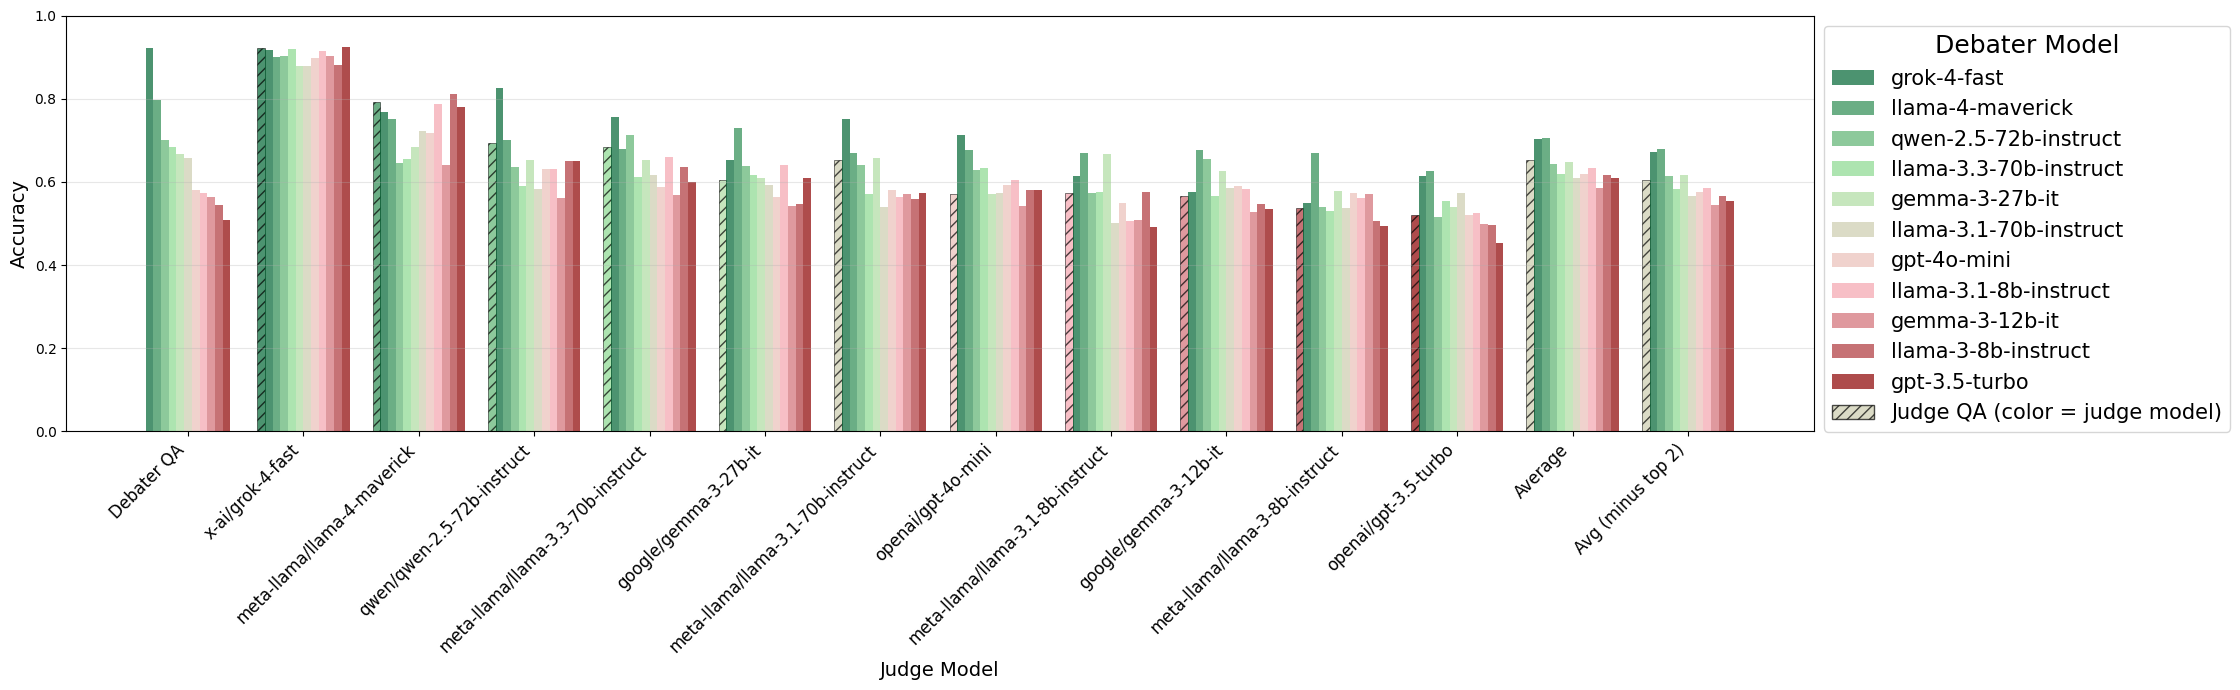

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

# Build debate_run_id_labels from debate run configs
debate_run_id_labels = {}
for debate_run_id in merged['debate_run_id'].unique():
    with open(f"../results/debates/{debate_run_id}.jsonl", "r") as f:
        debate_record = json.loads(f.readline())
    debater_model = debate_record['config']['debater_model']
    model_short = debater_model.split('/')[-1] if '/' in debater_model else debater_model
    debate_run_id_labels[debate_run_id] = model_short

# Create custom colormap: dark green -> light green -> light red -> dark red
colors_list = [
    (0.0, (0.0, 0.4, 0.2)),      # dark green
    (0.33, (0.6, 0.9, 0.6)),     # light green
    (0.67, (1.0, 0.71, 0.76)),   # light red
    (1.0, (0.55, 0.0, 0.0))      # dark red
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('green_yellow_red', colors_list)

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    # Sort debate runs by debater QA accuracy (highest to lowest)
    debater_scores = plot_data.groupby('debate_run_id')['debater_qa_acc'].first().sort_values(ascending=False)
    debate_run_ids = debater_scores.index.tolist()
    
    # Sort judge models by their corresponding debater QA accuracy (highest to lowest)
    judge_to_debater_acc = {}
    for judge_model in plot_data['model'].unique():
        for debate_run_id in debate_run_ids:
            debate_row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
            debater_model = debate_run_id_labels.get(debate_run_id, '')
            judge_model_short = judge_model.split('/')[-1] if '/' in judge_model else judge_model
            if debater_model == judge_model_short:
                judge_to_debater_acc[judge_model] = debate_row['debater_qa_acc']
                break
    
    judge_models = sorted(plot_data['model'].unique(), key=lambda x: judge_to_debater_acc.get(x, 0), reverse=True)
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    
    fig, ax = plt.subplots(figsize=(25, 7))
    
    colors = custom_cmap(np.linspace(0.0, 1.0, n_debates))
    
    # print("Debug: Order of debate_run_ids and labels:")
    # for i, debate_run_id in enumerate(debate_run_ids):
    #     label = debate_run_id_labels.get(debate_run_id, debate_run_id)
    #     print(f"  {i}: {debate_run_id} -> {label}")
    
    group_width = 0.8
    width = group_width / (n_debates + 1)
    
    x_labels = ['Debater QA'] + judge_models
    x_positions = np.arange(len(x_labels))
    
    # Group 0: Debater QA bars (one per debate run)
    for i, debate_run_id in enumerate(debate_run_ids):
        row = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]
        debater_qa_acc = row['debater_qa_acc']
        offset = (i - n_debates / 2 + 0.5) * width
        ax.bar(0 + offset, debater_qa_acc, width, color=colors[i], alpha=0.7)
    
    # Create mapping from judge model to debate_run_id (and thus color)
    judge_to_debate_run = {}
    for _, row in plot_data[['model', 'debate_run_id']].drop_duplicates('model').iterrows():
        judge_model_key = row['model']
        for debate_idx, drid in enumerate(debate_run_ids):
            debate_row = plot_data[plot_data['debate_run_id'] == drid].iloc[0]
            debater_model = debate_run_id_labels.get(drid, '')
            judge_model_short = judge_model_key.split('/')[-1] if '/' in judge_model_key else judge_model_key
            if debater_model == judge_model_short:
                judge_to_debate_run[judge_model_key] = debate_idx
                break
    
    # Groups 1 to n_judges: Judge QA + Verdicts
    for judge_idx, judge_model in enumerate(judge_models):
        x_pos = judge_idx + 1
        
        # First bar: Judge QA with hatch pattern in debater color
        judge_row = plot_data[plot_data['model'] == judge_model].iloc[0]
        judge_qa_acc = judge_row['judge_qa_acc']
        offset = (0 - (n_debates + 1) / 2 + 0.5) * width
        judge_color_idx = judge_to_debate_run.get(judge_model, 0)
        ax.bar(x_pos + offset, judge_qa_acc, width, color=colors[judge_color_idx], alpha=0.7, hatch='///', edgecolor='black', linewidth=0.5)
        
        # Remaining bars: Verdicts for each debate run
        for i, debate_run_id in enumerate(debate_run_ids):
            row = plot_data[(plot_data['model'] == judge_model) & 
                           (plot_data['debate_run_id'] == debate_run_id)]
            if len(row) > 0:
                verdict_acc = row['verdict_acc'].values[0]
                offset = ((i + 1) - (n_debates + 1) / 2 + 0.5) * width
                ax.bar(x_pos + offset, verdict_acc, width, color=colors[i], alpha=0.7)
    
    # Add Average groups
    for avg_idx, (avg_label, qa_val, verdict_series) in enumerate([
        ('Average', qa_avg, verdict_avg),
        ('Avg (minus top 2)', qa_avg_minus2, verdict_avg_minus2)
    ]):
        x_pos = len(judge_models) + 1 + avg_idx
        x_labels.append(avg_label)
        
        # First bar: Average Judge QA
        offset = (0 - (n_debates + 1) / 2 + 0.5) * width
        avg_color = custom_cmap(0.5)
        ax.bar(x_pos + offset, qa_val, width, color=avg_color, alpha=0.7, hatch='///', edgecolor='black', linewidth=0.5)
        
        # Remaining bars: Average Verdicts for each debate run
        for i, debate_run_id in enumerate(debate_run_ids):
            debater_model_full = plot_data[plot_data['debate_run_id'] == debate_run_id].iloc[0]['config_debater_model_debates']
            verdict_val = verdict_series[debater_model_full]
            offset = ((i + 1) - (n_debates + 1) / 2 + 0.5) * width
            ax.bar(x_pos + offset, verdict_val, width, color=colors[i], alpha=0.7)
    
    x_positions = np.arange(len(x_labels))
    
    ax.set_xlabel('Judge Model', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
    
    from matplotlib.patches import Patch
    
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)}"
        legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, label=label))
    
    judge_qa_color = custom_cmap(0.5)
    legend_elements.append(Patch(facecolor=judge_qa_color, alpha=0.7, hatch='///', edgecolor='black', label='Judge QA (color = judge model)'))
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Debater Model', fontsize=15, title_fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()